<h3>Typage et Entrée/Sortie</h3> 

un patient = une liste [durée d'intervention,chirurgien,jour d'opération,durée en sspi réveil et entrée]

on convertit cette liste une une liste de durée sur chaque machine. Il y'a 4 machines.
M0=brancardage, M1=SSPI entrée, M2 = ALR, M3=bloc, M4 = SSPI réveil.

ordo = [[1,3,4,2,3],[1,3,1,4,1],...]
On applique l'algorithme d'ordonnancement : 
    algo(liste de listes de durée) -> (liste de listes de durée)

On applique l'algorithme de lecture : 
    lecture(liste de listes) -> (liste de listes d'horaire de début, liste de listes de durée)

In [5]:
import matplotlib.pyplot as plt

<h3> Fonction de lecture et de calcul de coût </h3>

In [2]:
#La lecture enchaine les opérations au bloc avec 10 minutes d'écarts (Nettoyage du bloc)
#Le principe est de faire en sorte que le brancardage et SSPI d'entrée soit fait pile à tant pour l'opération 

def Lecture(ordo, h0): 
    liste = [[h0-ordo[0][0]-ordo[0][1], h0-ordo[0][1], h0, h0 + ordo[0][2]]]
    n = len(ordo)
    i = 1
    while i < n : 
        tBlocLibre = liste[-1][2] + ordo[i-1][2] + 10 #10 minutes après la fin de l'opération précédente 
        li = [tBlocLibre-ordo[i][0]-ordo[i][1], tBlocLibre-ordo[i][1], tBlocLibre, tBlocLibre+ordo[i][2]]
        liste.append(li)
        i+=1
    return liste
             
# Calcul le cout temporel total (du premier brancardage au dernier réveil en SSPI) 
# et le temps passé en bloc (de h0 à sorti de la dernière opération)
def cout(ordo): 
    liste = Lecture(ordo, 0)
    debutPremierActe = 0 
    finDernierActe = 0 
    ifinal = 0 
    
    for i in range (len(liste)) : 
        debutPremierActe = min(liste[i][0], debutPremierActe)
        finDernierActe = max(liste[i][3]+ordo[i][3], finDernierActe)
            
    coutTotal = finDernierActe - debutPremierActe 
    coutBloc = liste[-1][3] 
    return coutTotal, coutBloc

In [34]:
def diagrammeGantt(ordo):
    starts = Lecture(ordo,25)
    couleurs = ['blue', 'red', 'green', 'yellow', 'black', 'purple', 'pink', 'orange', 'grey', 'brown']  # Couleurs pour les tâches"
    Machines = ["Brancardage", "SSPI Entrée", "Bloc", "SSPI Réveil"]

    fig, ax = plt.subplots(figsize=(10, 6))
    
    for indicePatient, patient in enumerate(ordo):
        for i, tempsTache in enumerate(patient):
            ax.barh(f'{Machines[i]}', tempsTache, left=starts[indicePatient][i], color=couleurs[indicePatient])

    ax.set_xlabel('Temps')
    ax.set_ylabel('Machines')
    ax.set_title('Diagramme de Gantt')
    ax.invert_yaxis()  # Inverser l'axe Y pour avoir la machine 1 en haut

    plt.show()

<h4>Test de ces fonctions</h4>

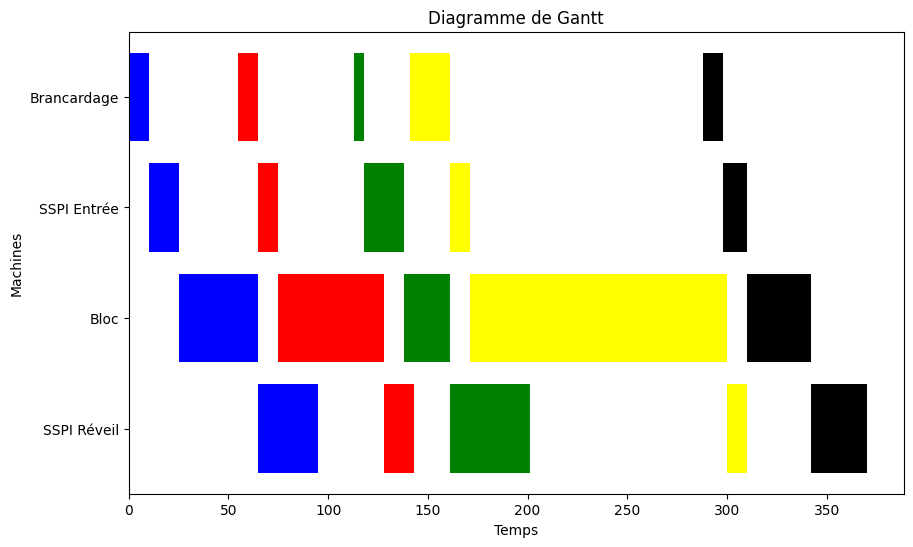

In [35]:
ordo = [[10,15,40,30],[10,10,53,15],[5,20,23,40],[20,10,129,10],[10,12,32,28]]
Lecture(ordo, 25)
diagrammeGantt(ordo)